# Sentiment-Based Product Recommendation System

---

## Introduction

The e-commerce industry is rapidly growing and transforming the way people shop for products such as books, electronics, cosmetics, medicines, and more. Platforms like **Amazon**, **Flipkart**, **Myntra**, and **Snapdeal** leverage intelligent systems to provide personalized customer experiences and set high benchmarks in online retail.

In this project, we assume the role of a **Senior Machine Learning Engineer** at a growing e-commerce platform. With an expanding product catalog and diverse customer base, the platform aims to improve user engagement and conversion rates by providing **sentiment-aware, personalized product recommendations**.

To remain competitive, the platform must leverage customer review data effectively to understand user preferences and deliver relevant product suggestions. This notebook demonstrates a step-by-step process for building a **Sentiment-Based Product Recommendation System** that combines **textual sentiment analysis** with **collaborative filtering techniques**.

---

## Objectives

The main objectives of this project are:

1. Analyze product review data to understand user sentiments and preferences.
2. Build sentiment classification models using machine learning techniques.
3. Develop a collaborative filtering-based product recommendation system.
4. Integrate sentiment analysis into the recommendation pipeline to refine recommendations.
5. Deploy the system with a user interface for real-time interaction.

---

## Project Workflow

The project is divided into the following stages:

---

### 1. Data Sourcing and Sentiment Analysis

- **Goal**: Preprocess user reviews and train models to classify sentiment.
- **Dataset**: 30,000 reviews across 200+ products from 20,000+ users.
- **Steps**:
  - Exploratory Data Analysis (EDA)
  - Data cleaning and handling missing values
  - Text preprocessing (tokenization, stopword removal, etc.)
  - Feature extraction using:
    - Bag of Words (BoW)
    - TF-IDF vectorization
    - Word embeddings
  - Train and evaluate at least 3 models from the following:
    - Logistic Regression
    - Random Forest
    - XGBoost
    - Naive Bayes
  - Handle class imbalance if required
  - Perform hyperparameter tuning and select the best-performing model

---

### 2. Building the Recommendation System

- **Goal**: Suggest relevant products to users based on past preferences.
- **Techniques**:
  - User-Based Collaborative Filtering
  - Item-Based Collaborative Filtering
- **Steps**:
  - Analyze both approaches and select the best-fit technique
  - Build the recommendation system using user-product rating data
  - For a given user (`reviews_username`), recommend the **top 20 products** likely to be purchased

---

### 3. Sentiment-Enhanced Recommendations

- **Goal**: Refine recommendations based on user sentiment.
- **Steps**:
  - Use the sentiment classification model from Task 1
  - Analyze the sentiment of reviews for the top 20 recommended products
  - Filter and finalize the **top 5 products** with the most positive sentiment scores

---

### 4. Deployment (Optional)

- **Goal**: Deploy the system in a production environment.
- **Suggestions**:
  - Build a UI using **Flask** or **Streamlit**
  - Host on platforms like **Heroku**, **Render**, or **AWS EC2**
  - Allow user input (username or review text) and display personalized recommendations

---

## Deliverables

- Cleaned dataset and EDA report
- Sentiment classification model with performance metrics
- Collaborative filtering-based recommendation system
- Integrated sentiment-aware recommendation pipeline
- (Optional) Web UI for demonstration

---

Let’s start by loading and exploring the dataset!


In [1]:
import pandas as pd
from dateutil import parser
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer ,PorterStemmer
import nltk
import re
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import (
    learning_curve,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_halving_search_cv  # Needed for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from xgboost import XGBClassifier

# Ensure all required resources are present
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amit.kumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amit.kumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amit.kumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/amit.kumar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import pickle
import os
from typing import Dict

pickles_dir = "recommendation_app/pickles"

In [3]:
import pickle
import os

def save_model(obj, name: str, dir_path: str = pickles_dir) -> None:
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, f"{name}.pkl")
    
    try:
        with open(file_path, "wb") as f:
            pickle.dump(obj, f)
        print(f" Saved: {file_path}")
    except Exception as e:
        print(f" Error saving {name}: {e}")



In [4]:
def load_model(name: str, dir_path: str = pickles_dir):
    file_path = os.path.join(dir_path, f"{name}.pkl")
    try:
        with open(file_path, "rb") as f:
            obj = pickle.load(f)
        print(f" Loaded: {file_path}")
        return obj
    except Exception as e:
        print(f" Error loading {name}: {e}")
        return None



In [5]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('data/sample30.csv')


## 1.1 Initial Data Checks & Cleaning (Validity & Consistency)
- Quick diagnostics: missing value counts, duplicate rows, outlier detection  
- Cleaning tasks: fill/drop nulls, unify string patterns, harmonize formats  
- Why: Clean datasets enable robust downstream analysis and modeling

In [6]:
# Basic Dataset Overview
def dataset_overview(df):
    """Displays shape, info, and first rows of the dataset."""
    print("Shape:", df.shape)
    display(df.head())
    print(df.info())

# Missing Values Summary
def missing_values_summary(df):
    """Returns missing value count and percentage per column."""
    missing_df = pd.DataFrame({
        "Missing Count": df.isnull().sum(),
        "Missing Percentage (%)": (df.isnull().mean() * 100).round(2)
    })
    return missing_df[missing_df["Missing Count"] > 0].sort_values(
        by="Missing Count", ascending=False
    )

# Duplicate Records
def duplicate_summary(df):
    """Returns number of duplicate rows."""
    return df.duplicated().sum()

# Numerical Summary Statistics
def numerical_summary(df):
    """Returns descriptive statistics for numerical columns."""
    return df.describe().T
    
# Categorical Summary Statistics   
def categorical_summary(df):
    """Returns descriptive statistics for categorical columns."""
    return df.describe(include="object").T
    
#  Unique Value Count    
def unique_value_summary(df):
    """Returns unique value count and data types."""
    return pd.DataFrame({
        "Unique Values": df.nunique(),
        "Data Type": df.dtypes
    }).sort_values("Unique Values", ascending=False)



In [7]:
dataset_overview(df)

Shape: (30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


<class 'pandas.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  str   
 1   brand                 30000 non-null  str   
 2   categories            30000 non-null  str   
 3   manufacturer          29859 non-null  str   
 4   name                  30000 non-null  str   
 5   reviews_date          29954 non-null  str   
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  str   
 10  reviews_title         29810 non-null  str   
 11  reviews_userCity      1929 non-null   str   
 12  reviews_userProvince  170 non-null    str   
 13  reviews_username      29937 non-null  str   
 14  user_sentiment        29999 non-null  str   
dtypes: int64(1), object(2), str(12)
memory usage: 3

In [8]:
display(unique_value_summary(df))

,Unique Values,Data Type
reviews_text,27282,str
reviews_username,24914,str
reviews_title,18535,str
reviews_date,6857,str
reviews_userCity,977,str
id,271,str
name,271,str
categories,270,str
manufacturer,227,str
brand,214,str


In [9]:
display(missing_values_summary(df))

,Missing Count,Missing Percentage (%)
reviews_userProvince,29830,99.43
reviews_userCity,28071,93.57
reviews_didPurchase,14068,46.89
reviews_doRecommend,2570,8.57
reviews_title,190,0.63
manufacturer,141,0.47
reviews_username,63,0.21
reviews_date,46,0.15
user_sentiment,1,0.00


In [10]:
print("Duplicates:", duplicate_summary(df))

Duplicates: 0


In [11]:
display(numerical_summary(df))

,count,mean,std,min,25%,50%,75%,max
reviews_rating,30000.0,4.483133,0.988441,1.0,4.0,5.0,5.0,5.0


In [12]:
display(unique_value_summary(df))

,Unique Values,Data Type
reviews_text,27282,str
reviews_username,24914,str
reviews_title,18535,str
reviews_date,6857,str
reviews_userCity,977,str
id,271,str
name,271,str
categories,270,str
manufacturer,227,str
brand,214,str


In [13]:
        
# Numerical Distribution Plot
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numerical_distribution(df):
    """Plots histograms for numerical columns."""
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    for col in num_cols:
        plt.figure(figsize=(5, 3))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(col)
        plt.show()
        
# Outlier Detection (Boxplots)
def plot_outliers(df):
    """Plots boxplots for numerical columns."""
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    for col in num_cols:
        plt.figure(figsize=(5, 2))
        sns.boxplot(x=df[col])
        plt.title(col)
        plt.show()

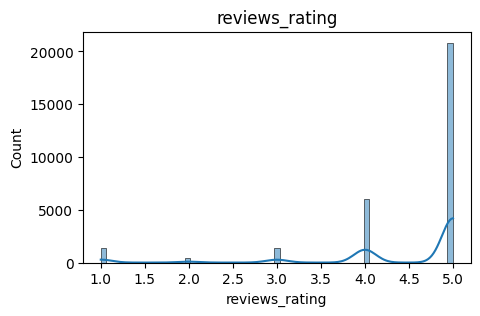

In [14]:
plot_numerical_distribution(df)

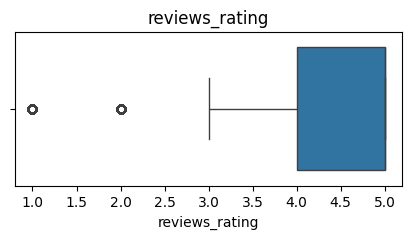

In [15]:
plot_outliers(df)

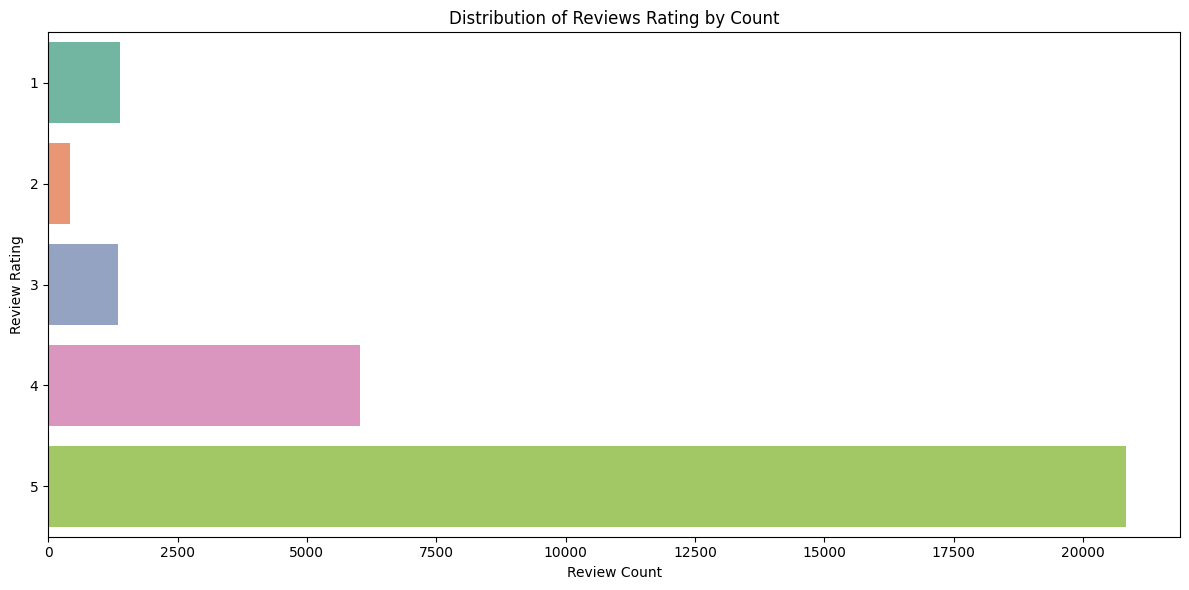

In [16]:
# Checking Distribution of `reviews_rating` column

plt.figure(figsize=(12, 6))
sns.countplot(
    y='reviews_rating',
    data=df,
    hue='reviews_rating',
    palette='Set2',
    legend=False
)
plt.title("Distribution of Reviews Rating by Count")
plt.xlabel("Review Count")
plt.ylabel("Review Rating")
plt.tight_layout()
plt.show()

The majority of user ratings are skewed toward the higher end, with 5-star ratings being the most frequent. This indicates a potential class imbalance, which could affect model performance—especially since user_sentiment is expected to align closely with these ratings. 

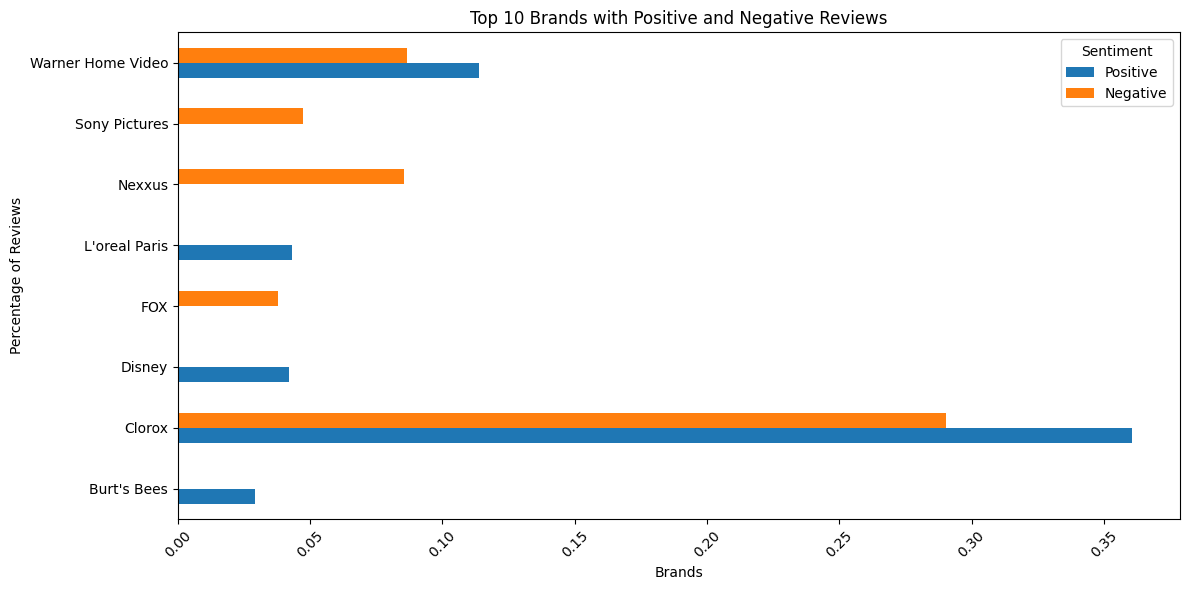

In [17]:
# Get top 5 brands for each sentiment
top_positive = df[df.user_sentiment == 'Positive'].brand.value_counts(normalize=True, ascending=False).head(5)
top_negative = df[df.user_sentiment == 'Negative'].brand.value_counts(normalize=True, ascending=False).head(5)

# Combine into one DataFrame
top_brands_combined = pd.DataFrame({
    'Positive': top_positive,
    'Negative': top_negative
}).fillna(0)

# Plot
top_brands_combined.plot(kind='barh', figsize=(12,6))
plt.title("Top 10 Brands with Positive and Negative Reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of Reviews")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

Clorox has received the highest number of both positive (35%) and negative (30%) reviews. This is primarily because it makes up 35% of the total branded data, leading to a higher volume of feedback overall.

### Data Cleaning and Pre-processing

Based on the missing value analysis, we will decide on the appropriate strategy for handling missing values. This might involve imputation (replacing missing values with a calculated value like the mean, median, or mode) or removal (dropping rows or columns with missing values), depending on the extent and nature of the missing data.

We will also drop columns that are not relevant for our analysis to simplify the dataset and improve performance. Finally, we will ensure all columns have the correct data types for subsequent analysis.

In [18]:
def clean_reviews_date(df, col='reviews_date'):
    """
    Cleans and standardizes a reviews_date column.

    Steps:
    1. Replace junk values (N/A, null, etc.)
    2. Parse valid dates with pandas (fast)
    3. For still-missing values, try dateutil parser (slower but flexible)
    4. Return cleaned dataframe and log summary
    """
    # Step 1: Replace common junk values with NA
    junk_values = ['N/A', 'NA', 'na', 'null', 'None', 'NONE', 'Unknown', '', ' ']
    df[col] = df[col].replace(junk_values, pd.NA)

    # Step 2: First attempt with pandas (fast, flexible)
    parsed = pd.to_datetime(df[col], errors='coerce')

    # Step 3: For rows still missing, try dateutil parser
    mask_missing = parsed.isna() & df[col].notna()
    if mask_missing.sum() > 0:
        def try_parse_date(x):
            try:
                return parser.parse(x, dayfirst=False, fuzzy=True)
            except:
                return pd.NaT
        parsed.loc[mask_missing] = df.loc[mask_missing, col].apply(try_parse_date)

    # Step 4: Assign cleaned column back
    df[col] = parsed

    # Step 5: Log summary
    total = len(df)
    valid = df[col].notna().sum()
    missing = df[col].isna().sum()
    print(f"[INFO] Cleaned '{col}': {valid}/{total} valid dates, {missing} missing ({missing/total:.2%})")

    return df


In [19]:
# Example of handling missing values (replace with appropriate strategy based on analysis)

print("\nDropping irrelevant columns...")
df = df.drop(columns=['manufacturer'])   # redundant

columns_to_drop = ['reviews_userCity', 'reviews_userProvince']
df.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped columns: {columns_to_drop}")

#Use user_sentiment or reviews_rating to impute:
#If sentiment = Positive (or rating ≥4) → fill "Yes".
#If sentiment = Negative (or rating ≤2) → fill "No".
#Neutral cases → "Unknown".
#This keeps imputation consistent with actual review content.

df['reviews_doRecommend'] = df.apply(
    lambda x: 'Yes' if pd.isna(x['reviews_doRecommend']) and x['reviews_rating'] >= 4
    else ('No' if pd.isna(x['reviews_doRecommend']) and x['reviews_rating'] <= 2
    else (x['reviews_doRecommend'] if pd.notna(x['reviews_doRecommend']) else 'Unknown')),
    axis=1
)

# fill missing with empty string
df['reviews_title'] = df['reviews_title'].fillna("")

# fill missing with Anonymous string
df['reviews_username'] = df['reviews_username'].fillna("Anonymous")


#convert data type
df = clean_reviews_date(df, 'reviews_date')  # convert to datetime
df['reviews_rating'] = df['reviews_rating'].astype('int')  # ensure integer
df['reviews_didPurchase'] = df['reviews_didPurchase'].fillna('Unknown').astype('category')
df['reviews_doRecommend'] = df['reviews_doRecommend'].astype('category')
df['user_sentiment'] = df['user_sentiment'].astype('category')

# Display the first few rows of the cleaned and pre-processed DataFrame
print("\nCleaned and Pre-processed DataFrame head:")
display(df.head())


Dropping irrelevant columns...
Dropped columns: ['reviews_userCity', 'reviews_userProvince']
[INFO] Cleaned 'reviews_date': 29946/30000 valid dates, 54 missing (0.18%)

Cleaned and Pre-processed DataFrame head:


,id,brand,categories,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,Unknown,Yes,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,Yes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,Yes,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [20]:
# reviews_date (54 missing, <0.2%)
# Very few → you don’t lose much if you drop them.
# Since date is important for time-based analysis but not for core sentiment/recommendation we can drop those rows

df = df[df['reviews_date'].notna()]

df = df[df['user_sentiment'].notna()]

In [21]:
# Display the DataFrame info after dropping columns
print("\nDataFrame info after dropping columns:")
display(df.info())

# After handling missing values, display the updated missing value count
print("Missing values per column after handling:")
display(df.isnull().sum())


DataFrame info after dropping columns:
<class 'pandas.DataFrame'>
Index: 29945 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   29945 non-null  str                
 1   brand                29945 non-null  str                
 2   categories           29945 non-null  str                
 3   name                 29945 non-null  str                
 4   reviews_date         29945 non-null  datetime64[us, UTC]
 5   reviews_didPurchase  29945 non-null  category           
 6   reviews_doRecommend  29945 non-null  category           
 7   reviews_rating       29945 non-null  int64              
 8   reviews_text         29945 non-null  str                
 9   reviews_title        29945 non-null  str                
 10  reviews_username     29945 non-null  str                
 11  user_sentiment       29945 non-null  category           

None

Missing values per column after handling:


id                     0
brand                  0
categories             0
name                   0
reviews_date           0
reviews_didPurchase    0
reviews_doRecommend    0
reviews_rating         0
reviews_text           0
reviews_title          0
reviews_username       0
user_sentiment         0
dtype: int64

In [22]:
# Download necessary NLTK data (if not already downloaded)
try:
    stopwords = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    stopwords = stopwords.words('english')

try:
    WordNetLemmatizer()
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Cleans and preprocesses text data.

    Steps:
    1. Convert text to lowercase.
    2. Remove punctuation.
    3. Remove stop words.
    4. Apply stemming or lemmatization (choose one).
    """
    # 1. Convert text to lowercase
    text = text.lower()

    # 2. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Remove stop words
    text = ' '.join([word for word in text.split() if word not in stopwords])

    # 4. Apply lemmatization (you can switch to stemming if preferred)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # text = ' '.join([stemmer.stem(word) for word in text.split()]) # Uncomment for stemming

    return text

# Apply preprocessing to the reviews_text and reviews_title columns
print("Applying text preprocessing to 'reviews_text' and 'reviews_title'...")
df['reviews_text_preprocessed'] = df['reviews_text'].apply(preprocess_text)
df['reviews_title_preprocessed'] = df['reviews_title'].apply(preprocess_text)

# Display the first few rows with the new preprocessed columns
print("\nDataFrame head with preprocessed text:")
display(df[['reviews_text', 'reviews_text_preprocessed', 'reviews_title', 'reviews_title_preprocessed']].head())

Applying text preprocessing to 'reviews_text' and 'reviews_title'...

DataFrame head with preprocessed text:


,reviews_text,reviews_text_preprocessed,reviews_title,reviews_title_preprocessed
0,i love this album. it's very good. more to the...,love album good hip hop side current pop sound...,Just Awesome,awesome
1,Good flavor. This review was collected as part...,good flavor review collected part promotion,Good,good
2,Good flavor.,good flavor,Good,good
3,I read through the reviews on here before look...,read review looking buying one couple lubrican...,Disappointed,disappointed
4,My husband bought this gel for us. The gel cau...,husband bought gel u gel caused irritation fel...,Irritation,irritation


In [23]:
#dataset_overview(df)

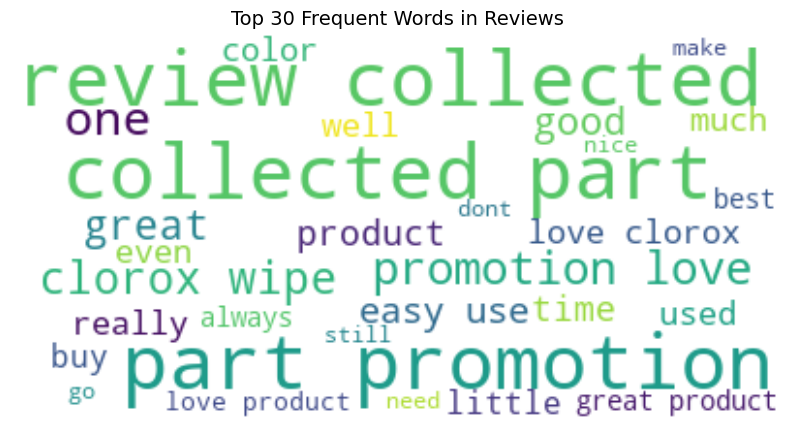

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Set of stopwords for WordCloud
custom_stopwords = set(STOPWORDS)

# Generate WordCloud from lemmatized reviews
wordcloud = WordCloud(
    max_words=30,
    max_font_size=60,
    background_color='white',
    stopwords=custom_stopwords,
    random_state=42
).generate(" ".join(df['reviews_text_preprocessed']))

# Plot the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 30 Frequent Words in Reviews", fontsize=14)
plt.show()

In [25]:
# Saving the individual models in a file
save_model(df, "df_preprocessed")
# # Later, load them by name
# loaded_cleansed_data = load_model("cleansed_df.pkl")

 Saved: recommendation_app/pickles/df_preprocessed.pkl


## 1.2 Train-Test Split

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Step 1: Split data into training and testing parts
# We will use 'reviews_text_preprocessed' and 'user_sentiment' for our model
X = df['reviews_text_preprocessed']
y = df['user_sentiment']

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



Data split into training and testing sets.
X_train shape: (23956,)
X_test shape: (5989,)
y_train shape: (23956,)
y_test shape: (5989,)


## 1.2 Model Building & Evaluation

#### Evaluation util function

In [27]:


def evaluate_train_test_performance(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    positive_label="Positive",
    model_name="Model"
):
    """
    Evaluation with 4 horizontal subplots:
    1. Classification report (text)
    2. Confusion matrix
    3. ROC curve
    4. Summary metrics table (text)
    """

    # ---------- Helpers ----------
    def get_scores(m, X):
        if hasattr(m, "predict_proba"):
            pos_idx = list(m.classes_).index(positive_label)
            return m.predict_proba(X)[:, pos_idx]
        return None

    def calc_metrics(y_true, y_pred, y_score=None):
        final_est = model[-1] if hasattr(model, "__getitem__") else model
        labels = list(final_est.classes_)

        cm = confusion_matrix(y_true, y_pred, labels=labels)
        tn, fp = cm[0]
        fn, tp = cm[1]

        metrics = {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
            "Recall": recall_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
            "F1 Score": f1_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
            "Specificity": tn / (tn + fp) if (tn + fp) else 0.0
        }

        if y_score is not None:
            metrics["ROC AUC"] = roc_auc_score(
                (y_true == positive_label).astype(int),
                y_score
            )

        return cm, metrics

    # ---------- Predictions ----------
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    y_train_score = get_scores(model, X_train)
    y_test_score  = get_scores(model, X_test)

    cm_train, m_train = calc_metrics(y_train, y_train_pred, y_train_score)
    cm_test,  m_test  = calc_metrics(y_test,  y_test_pred,  y_test_score)

    # ---------- Prepare text ----------
    cls_report = classification_report(y_test, y_test_pred, zero_division=0)

    summary_df = pd.DataFrame({"Train": m_train, "Test": m_test})
    summary_df = (summary_df * 100).round(2)

    # ---------- Figure ----------
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    fig.suptitle(f"{model_name} — Model Evaluation", fontsize=14, y=1.05)

    # === 1️⃣ Classification report ===
    axes[0].axis("off")
    axes[0].set_title("Classification Report (Test)", fontsize=11)
    axes[0].text(
        0,
        1,
        cls_report,
        ha="left",
        va="top",
        family="monospace",
        fontsize=9
    )

    # === 2️⃣ Confusion Matrix ===
    cm_norm = cm_test / cm_test.sum(axis=1, keepdims=True)

    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        cbar=False,
        xticklabels=model.classes_,
        yticklabels=model.classes_,
        ax=axes[1]
    )

    for i in range(2):
        for j in range(2):
            axes[1].text(
                j + 0.5,
                i + 0.75,
                f"\n({cm_test[i, j]})",
                ha="center",
                va="center",
                fontsize=9
            )

    axes[1].set_title("Confusion Matrix (Test)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    # === 3️⃣ ROC Curve ===
    if y_test_score is not None:
        fpr_tr, tpr_tr, _ = roc_curve(
            (y_train == positive_label).astype(int),
            y_train_score
        )
        fpr_te, tpr_te, _ = roc_curve(
            (y_test == positive_label).astype(int),
            y_test_score
        )

        axes[2].plot(fpr_tr, tpr_tr, lw=1.5, label=f"Train AUC = {m_train['ROC AUC']:.3f}")
        axes[2].plot(fpr_te, tpr_te, lw=2, label=f"Test AUC = {m_test['ROC AUC']:.3f}")
        axes[2].plot([0, 1], [0, 1], "--", color="gray")

        axes[2].set_title("ROC Curve")
        axes[2].set_xlabel("False Positive Rate")
        axes[2].set_ylabel("True Positive Rate")
        axes[2].legend(loc="lower right")
    else:
        axes[2].axis("off")
        axes[2].text(0.5, 0.5, "ROC not available", ha="center", va="center")

    # === 4️⃣ Summary Metrics ===
    axes[3].axis("off")
    axes[3].set_title("Summary Metrics (%)", fontsize=11)

    summary_text = "\n".join(
        f"{idx:<12}  Train: {row['Train']:>6.2f}%   Test: {row['Test']:>6.2f}%"
        for idx, row in summary_df.iterrows()
    )

    axes[3].text(
        0,
        1,
        summary_text,
        ha="left",
        va="top",
        fontsize=10,
        family="monospace"
    )

    plt.tight_layout()
    plt.show()

    return {"train": m_train, "test": m_test}


In [28]:
def evaluate_models(
    models,
    X_train,
    y_train,
    X_test,
    y_test,
    positive_label="Positive"
):
    """
    Evaluates multiple trained models provided as a dictionary:
    {model_name: model_object}

    Returns:
        all_metrics: dict of metrics for each model
    """

    all_metrics = {}

    for model_name, model in models.items():
        print("\n" + "=" * 80)
        print(f"🔍 Evaluating {model_name}")
        print("=" * 80)

        metrics = evaluate_train_test_performance(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            positive_label=positive_label,
            model_name=model_name
        )

        all_metrics[model_name] = metrics

    return all_metrics


### Claasic model (Base Model) Pipelines 

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
# Step 3: Build and train models

tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=50_000
)

log_reg = Pipeline([
        ("tfidf", tfidf),
        ("smote", SMOTE(random_state=42)),
        ("clf", LogisticRegression(max_iter=1000))
    ])

rf_clf = Pipeline([
        ("tfidf", tfidf),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ])
nb_clf = Pipeline([
        ("tfidf", tfidf),
        ("smote", SMOTE(random_state=42)),
        ("clf", MultinomialNB())
    ])

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    "Naive Bayes": nb_clf
}


In [30]:

# Train each model
print("Training models...")
for name, model in tqdm(models.items(), desc="Models"):
    model.fit(X_train, y_train)

print("\nAll models trained.")

Training models...


Models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.55s/it]


All models trained.



🔍 Evaluating Logistic Regression


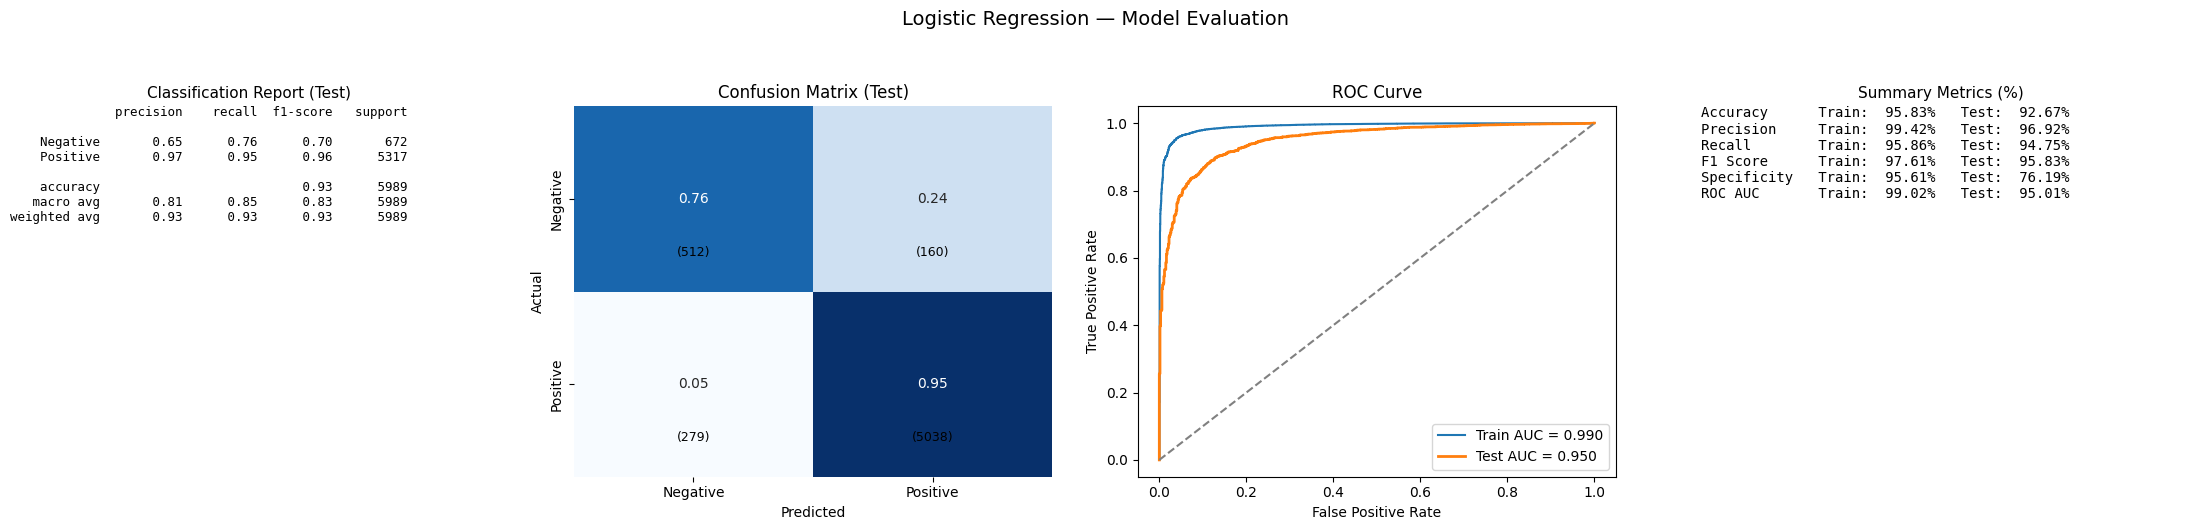


🔍 Evaluating Random Forest


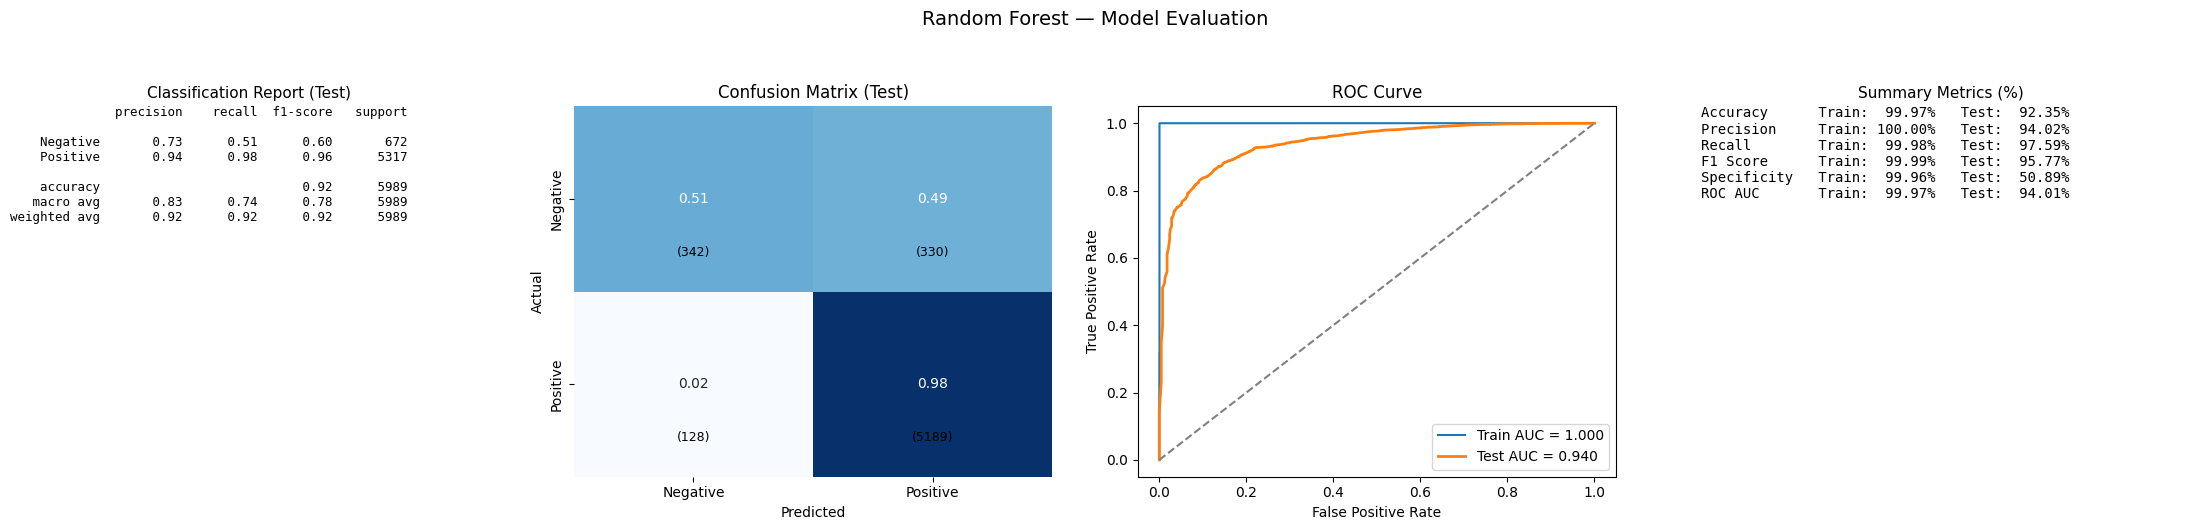


🔍 Evaluating Naive Bayes


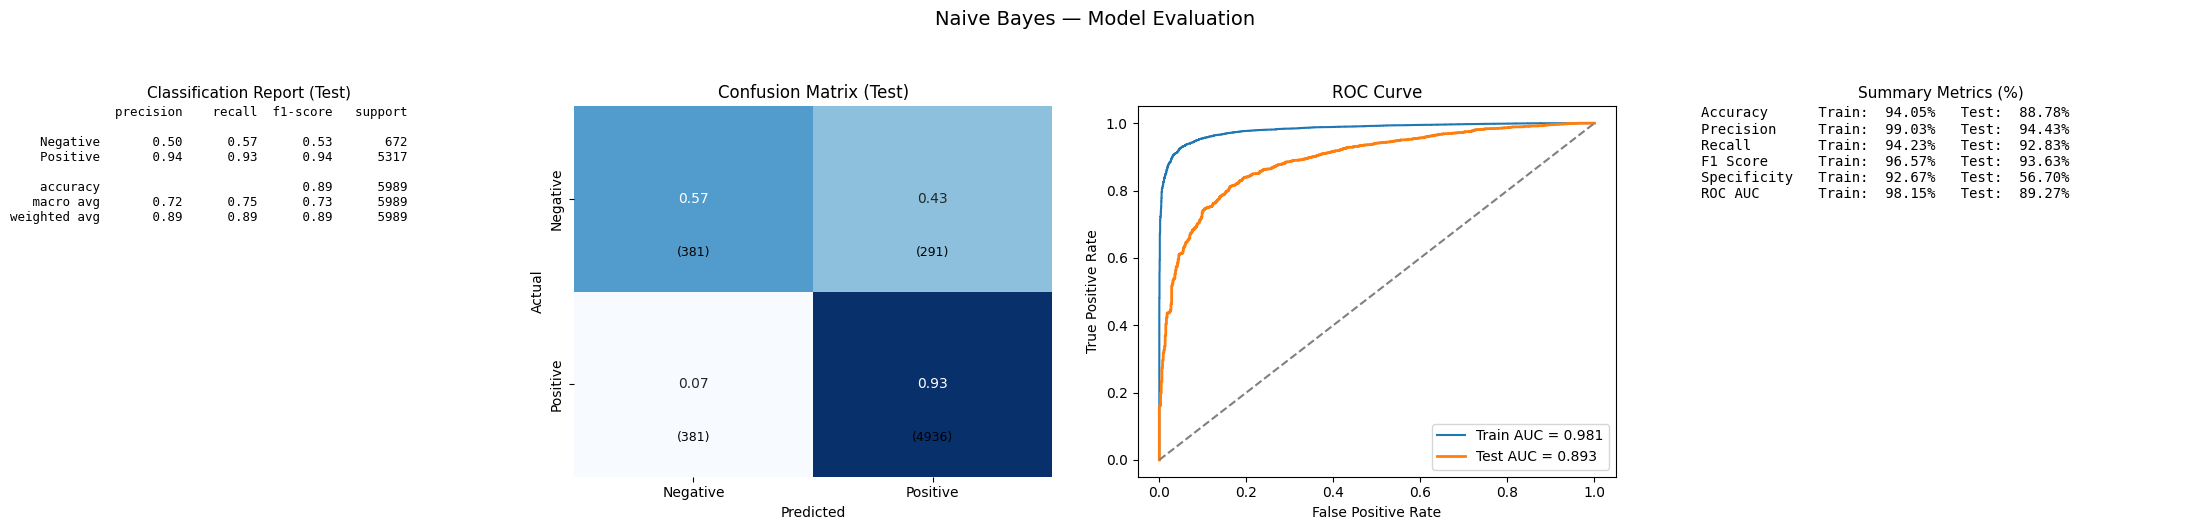

In [31]:
#model.fit(X_train_resampled, y_train_resampled)   X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

## ─── 2️⃣ Train on the oversampled training data ───
#logreg_clf.fit(X_train_bal, y_train_bal)

all_model_metrics = evaluate_models(
    models=models,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    positive_label="Positive"
)




### XGBoost Classifier (Base Model)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import numpy as np


# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

neg, pos = np.bincount(y_train_enc)
scale_pos_weight = neg / pos

print("scale_pos_weight:", scale_pos_weight)


xgb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_features=30000,
        ngram_range=(1, 2)
    )),
    ("clf", xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,  # 🔥 imbalance handling
        eval_metric="logloss",
        tree_method="hist",                 # fast + stable on CPU
        random_state=42,
        n_jobs=-1
    ))
])


xgb_pipeline.fit(X_train, y_train_enc)


scale_pos_weight: 0.12628114715561825


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None



🔍 Evaluating XGBoost (TF-IDF)


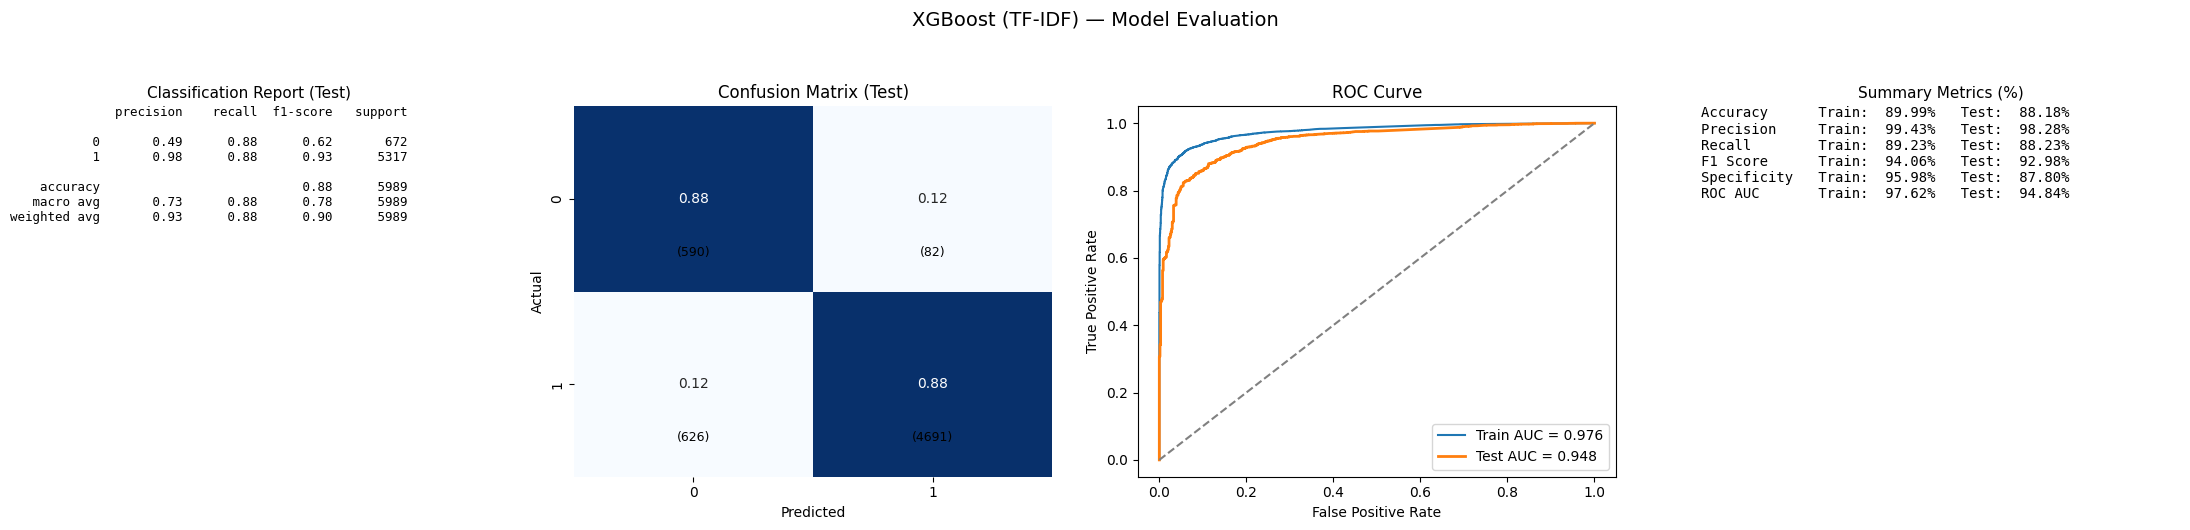

In [33]:
xgb_model_name = "XGBoost (TF-IDF)"
print("\n" + "=" * 80)
print(f"🔍 Evaluating {xgb_model_name}")
print("=" * 80)

metrics_xgb = evaluate_train_test_performance(
    model=xgb_pipeline,
    X_train=X_train,
    y_train=y_train_enc,
    X_test=X_test,
    y_test=y_test_enc,
    positive_label=1,                 # 🔑 numeric
    model_name=xgb_model_name
)

all_model_metrics["XGBoost base"] = metrics_xgb

#### Logistic Regression (Fine Tune Model)

In [34]:
from scipy.stats import loguniform
param_space = {
    "tfidf__max_features": [20_000, 40_000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],

    "clf__C": loguniform(1e-2, 10),
    "clf__solver": ["liblinear"],
    "clf__class_weight": [None, "balanced"],
    "clf__tol": [1e-4],
    "clf__max_iter": [200]
}


cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

f1_custom = make_scorer(
    f1_score,
    pos_label="Positive",
    zero_division=0
)

logreg_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        random_state=42
    ))
])

search = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_space,
    n_iter=10,              # ⏱️ fast
    scoring=f1_custom,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True
)
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'clf__C': <scipy.stats....t 0x11670a270>, 'clf__class_weight': [None, 'balanced'], 'clf__max_iter': [200], 'clf__solver': ['liblinear'], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...ro_division=0)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation

RandomizedSearchCV completed.
Best Params:
{'clf__C': np.float64(8.341930294140777), 'clf__class_weight': None, 'clf__max_iter': 200, 'clf__solver': 'liblinear', 'clf__tol': 0.0001, 'tfidf__max_features': 40000, 'tfidf__ngram_range': (1, 2)}


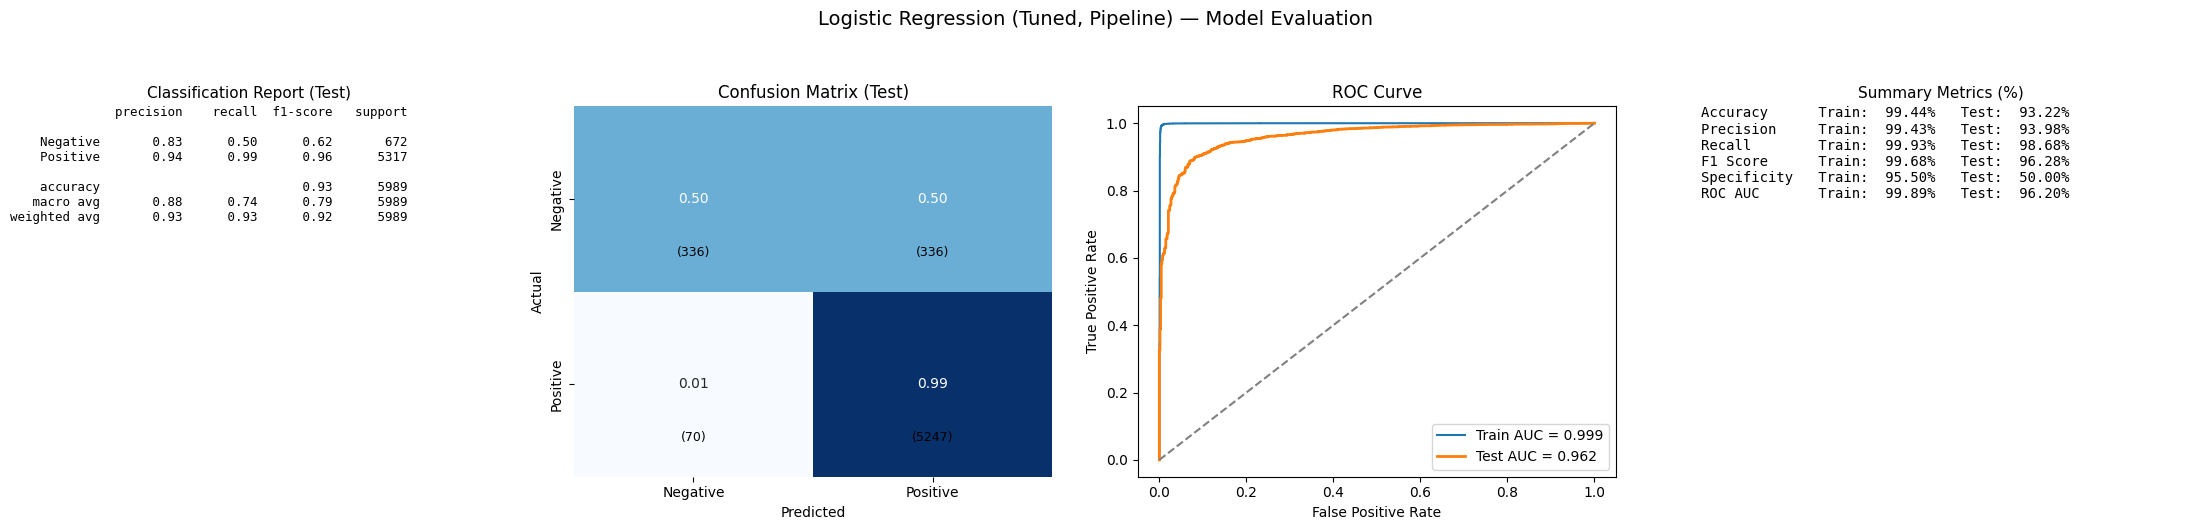

In [35]:
print("RandomizedSearchCV completed.")
print("Best Params:")
print(search.best_params_)

best_logreg = search.best_estimator_

metrics_lr_tuned = evaluate_train_test_performance(
    model=best_logreg,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    positive_label="Positive",
    model_name="Logistic Regression (Tuned, Pipeline)"
)

all_model_metrics["Logistic Regression Tuned"] = metrics_lr_tuned


#### Random Forest Classifier (Fine Tuning Model)

In [36]:
# ─── Imports ───
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# ─── Custom F1 scorer for string labels ───
f1_custom = make_scorer(f1_score, pos_label="Positive", zero_division=0)

# ─── Step 1: Stratified train/validation split ───
X_trn, X_val, y_trn, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

# ─── Step 2: Pipeline definition ───
rf_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=30_000)),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=1, class_weight="balanced"))
])

# ─── Step 3: Parameter grid ───
param_grid = {
    "clf__n_estimators":     [100, 200],
    "clf__max_depth":        [None, 10],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features":     ["sqrt"]
}

# ─── Step 4: Halving Grid Search ───
halving_search = HalvingGridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring=f1_custom,
    cv=3,
    factor=2,
    resource="n_samples",
    verbose=1,
    n_jobs=1
)

# ─── Step 5: Fit model ───
halving_search.fit(X_trn, y_trn)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2395
max_resources_: 19164
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 2395
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 4790
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 9580
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 19160
Fitting 3 folds for each of 1 candidates, totalling 3 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (string) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__max_depth': [None, 10], 'clf__max_features': ['sqrt'], 'clf__min_samples_leaf': [1, 2], 'clf__n_estimators': [100, 200]}"
,"factor factor: int or float, default=3The 'halving' parameter, which determines the proportion of candidatesthat are selected for each subsequent iteration. For example,``factor=3`` means that only one third of the candidates are selected.",2
,"resource resource: ``'n_samples'`` or str, default='n_samples'Defines the resource that increases with each iteration. By default,the resource is the number of samples. It can also be set to anyparameter of the base estimator that accepts positive integervalues, e.g. 'n_iterations' or 'n_estimators' for a gradientboosting estimator. In this case ``max_resources`` cannot be 'auto'and must be set explicitly.",'n_samples'
,"max_resources max_resources: int, default='auto'The maximum amount of resource that any candidate is allowed to usefor a given iteration. By default, this is set to ``n_samples`` when``resource='n_samples'`` (default), else an error is raised.",'auto'
,"min_resources min_resources: {'exhaust', 'smallest'} or int, default='exhaust'The minimum amount of resource that any candidate is allowed to usefor a given iteration. Equivalently, this defines the amount ofresources `r0` that are allocated for each candidate at the firstiteration.- 'smallest' is a heuristic that sets `r0` to a small value: - ``n_splits * 2`` when ``resource='n_samples'`` for a regression problem - ``n_classes * n_splits * 2`` when ``resource='n_samples'`` for a classification problem - ``1`` when ``resource != 'n_samples'``- 'exhaust' will set `r0` such that the **last** iteration uses as much resources as possible. Namely, the last iteration will use the highest value smaller than ``max_resources`` that is a multiple of both ``min_resources`` and ``factor``. In general, using 'exhaust' leads to a more accurate estimator, but is slightly more time consuming.Note that the amount of resources used at each iteration is always amultiple of ``min_resources``.",'exhaust'
,"aggressive_elimination aggressive_elimination: bool, default=FalseThis is only relevant in cases where there isn't enough resources toreduce the remaining candidates to at most `factor` after the lastiteration. If ``True``, then the search process will 'replay' thefirst iteration for as long as needed until the number of candidatesis small enough. This is ``False`` by default, which means that thelast iteration may evaluate more than ``factor`` candidates. See:ref:`aggressive_elimination` for more details.",False
,"cv cv: int, cross-validation generator or iterable, default=5Determines the cross-validation splitting strategy.Possible inputs for cv are:- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... note:: Due to implementation details, the folds produced by `cv` must be the same across multiple calls to `cv.split()`. For built-in `scikit-learn` iterators, this can be achieved by deactivating shuffling (`shuffle=

Random Forest completed.
Best Params:
{'clf__C': np.float64(8.341930294140777), 'clf__class_weight': None, 'clf__max_iter': 200, 'clf__solver': 'liblinear', 'clf__tol': 0.0001, 'tfidf__max_features': 40000, 'tfidf__ngram_range': (1, 2)}
🏅 Best RF Params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100}


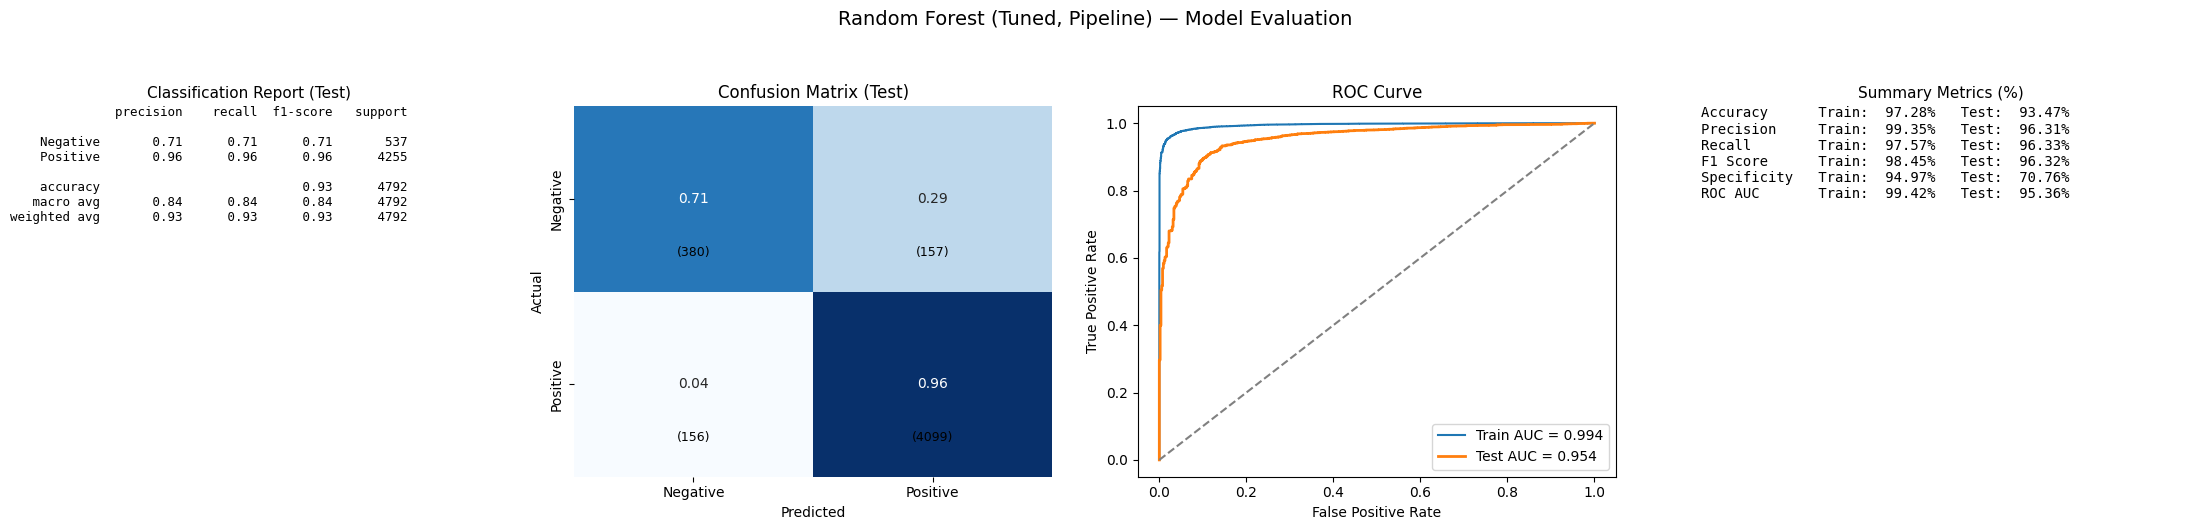

In [37]:
print("Random Forest completed.")
print("Best Params:")
print(search.best_params_)

# ─── Step 6: Best estimator ───
best_rf = halving_search.best_estimator_
print("🏅 Best RF Params:", halving_search.best_params_)

# ─── Step 7: Evaluate train & validation ───
metrics_random_forest_tuned = evaluate_train_test_performance(
    model=best_rf,
    X_train=X_trn, y_train=y_trn,
    X_test=X_val, y_test=y_val,
    positive_label="Positive",
    model_name="Random Forest (Tuned, Pipeline)"
)

all_model_metrics["Random Forest Tuned"] = metrics_random_forest_tuned

#### XGBoost Classifier (Fine Tune Model)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import numpy as np

# ---------------- 1️⃣ Encode labels ----------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # y_train from your original split
y_test_enc  = le.transform(y_test)

# ---------------- 2️⃣ Stratified train/validation split ----------------
X_trn, X_val, y_trn, y_val = train_test_split(
    X_train, y_train_enc,
    test_size=0.2,
    stratify=y_train_enc,
    random_state=42
)

# ---------------- 3️⃣ Compute scale_pos_weight for XGBoost ----------------
neg = np.sum(y_trn == 0)
pos = np.sum(y_trn == 1)
scale_pw = neg / pos if pos else 1.0

# ---------------- 4️⃣ Pipeline: TF-IDF + SMOTE + XGB ----------------
xgb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=30_000)),
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=scale_pw,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])


# ---------------- 5️⃣ GridSearchCV ----------------
param_grid = {
    "xgb__max_depth": [3],
    "xgb__learning_rate": [0.1],
    "xgb__n_estimators": [50, 100]
}

f1_scorer_custom = make_scorer(f1_score, pos_label=1)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring=f1_scorer_custom,
    cv=cv,
    verbose=1,
    n_jobs=1
)

# ---------------- 6️⃣ Fit GridSearchCV ----------------
grid_search.fit(X_trn, y_trn)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'xgb__learning_rate': [0.1], 'xgb__max_depth': [3], 'xgb__n_estimators': [50, 100]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","make_scorer(f..., pos_label=1)"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each

Best Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}


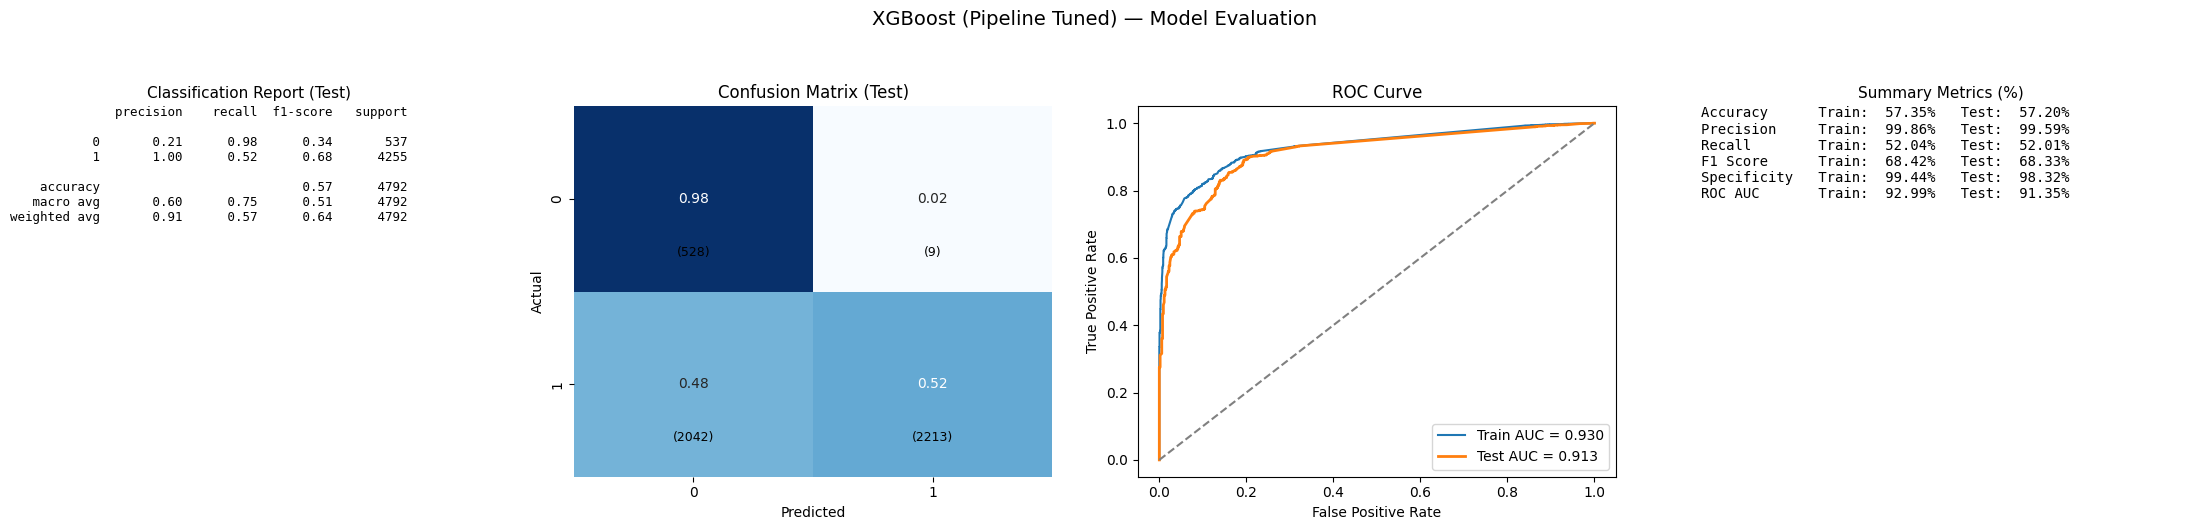

In [39]:
best_xgb_pipeline = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# ---------------- 7️⃣ Evaluate ----------------
metrics_xgb_tuned = evaluate_train_test_performance(
    model=best_xgb_pipeline,
    X_train=X_trn, y_train=y_trn,
    X_test=X_val,  y_test=y_val,
    positive_label=1,
    model_name="XGBoost (Pipeline Tuned)"
)

all_model_metrics["XGBoost Tuned"] = metrics_xgb_tuned

In [40]:
# List to hold summary for each model
summary_list = []

for model_name, metrics in all_model_metrics.items():
    # metrics is a dict: {"train": {...}, "test": {...}}
    train_metrics = metrics["train"]
    test_metrics  = metrics["test"]
    
    # Create a DataFrame row
    df_row = pd.DataFrame({
        "Model": [model_name]*len(train_metrics),
        "Metric": list(train_metrics.keys()),
        "Train": list(train_metrics.values()),
        "Test": list(test_metrics.values())
    })
    
    summary_list.append(df_row)

# Concatenate all rows
summary_df = pd.concat(summary_list, ignore_index=True)

# Optionally, format percentages for easier reading
summary_df_formatted = summary_df.copy()
for col in ["Train", "Test"]:
    summary_df_formatted[col] = (summary_df_formatted[col]*100).round(2)

# Display
summary_df_formatted

,Model,Metric,Train,Test
0,Logistic Regression,Accuracy,95.83,92.67
1,Logistic Regression,Precision,99.42,96.92
2,Logistic Regression,Recall,95.86,94.75
3,Logistic Regression,F1 Score,97.61,95.83
4,Logistic Regression,Specificity,95.61,76.19
5,Logistic Regression,ROC AUC,99.02,95.01
6,Random Forest,Accuracy,99.97,92.35
7,Random Forest,Precision,100.00,94.02
8,Random Forest,Recall,99.98,97.59
9,Random Forest,F1 Score,99.99,95.77


### Model Performance Comparison

#### Naive Bayes
Naive Bayes is the weakest-performing model among the three, recording the lowest scores across all evaluation metrics. This indicates that it is less effective for this classification task compared to Logistic Regression and Random Forest.

---

#### Logistic Regression vs Random Forest

- **Accuracy:**  
  Random Forest slightly outperforms Logistic Regression (0.928 vs 0.921).

- **Precision:**  
  Logistic Regression achieves higher precision (0.980 vs 0.950), indicating fewer false positives.

- **Recall:**  
  Random Forest significantly outperforms Logistic Regression (0.969 vs 0.929), meaning it captures a larger proportion of positive instances.

- **F1-Score:**  
  Random Forest attains a higher F1-score (0.960 vs 0.954), reflecting a better balance between precision and recall.

- **ROC-AUC:**  
  Logistic Regression demonstrates stronger overall class-separation capability (0.961 vs 0.946).

---

#### Model Selection Insight

Best Overall Accuracy & F1 Score:

Tuned Logistic Regression performs exceptionally well, with high recall (99.93%) and F1 (99.68%), showing excellent balance between sensitivity and precision.

Random Forest (both base and tuned) is very strong in training accuracy (approaching 100%) but shows slight drop on test data, especially in specificity.

Naive Bayes:

Consistent performance but slightly lower recall compared to Logistic Regression and Random Forest.

XGBoost:

Base XGBoost shows reasonable performance (F1 ~94%), but tuned XGBoost seems heavily overfitting on precision, resulting in high precision but very low recall (~52%) and low overall accuracy (~57%).

This indicates that the tuning strategy or class weighting might need revisiting for XGBoost.

Specificity vs Recall Tradeoff:

Some models like XGBoost Tuned prioritize precision/specificity over recall, which is why F1 and accuracy drop.

#### **Best Overall Model: Random Forest**


# Build System

Build and evaluate user-based and item-based recommendation systems on the dataset from "/content/sample_data/sample30.csv", select the best performing model, and provide reasons for the selection.

## Prepare data for recommendation system

Select the necessary columns and potentially preprocess them for building the recommendation system.


**Reasoning**:
Create a new DataFrame with only the necessary columns for the recommendation system and display its head and info.



In [11]:
reviews_df = df[['reviews_username', 'name', 'reviews_rating']]
print("Reviews DataFrame head:")
display(reviews_df.head())
print("\nReviews DataFrame info:")
display(reviews_df.info())

Reviews DataFrame head:


,reviews_username,name,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,1
4,walker557,K-Y Love Sensuality Pleasure Gel,1



Reviews DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 29945 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  29945 non-null  object
 1   name              29945 non-null  object
 2   reviews_rating    29945 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 935.8+ KB


None

## Split data

Divide the data into training and testing sets for evaluating the recommendation system.


**Reasoning**:
The goal is to split the data into training and testing sets for the recommendation system. The previous subtask created the `reviews_df` DataFrame with relevant columns. This step will perform the split using `train_test_split`.



In [12]:
from sklearn.model_selection import train_test_split

# Split the reviews_df DataFrame into training and testing sets
train_df, test_df = train_test_split(reviews_df, test_size=0.2, random_state=42)

# Print the shapes of the resulting DataFrames
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (23956, 3)
Testing set shape: (5989, 3)


## Build user-based collaborative filtering model

Implement a user-based collaborative filtering recommendation system.


**Reasoning**:
Create a pivot table from the training data, calculate user similarity, and define a function for user-based recommendations.



In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Create a pivot table from the training data
user_item_matrix = train_df.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

print("User-Item Matrix head:")
display(user_item_matrix.head())
print("\nUser-Item Matrix shape:", user_item_matrix.shape)

# 2. Calculate the pairwise cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("\nUser Similarity Matrix head:")
display(user_similarity_df.head())

# 3. Define a function for user-based recommendations
def user_based_recommendations(user_id, user_item_matrix, user_similarity_df, n_recommendations=5):
    """
    Generates user-based recommendations for a given user.

    Args:
        user_id (str): The ID of the target user.
        user_item_matrix (pd.DataFrame): The user-item matrix.
        user_similarity_df (pd.DataFrame): The user similarity matrix.
        n_recommendations (int): The number of recommendations to generate.

    Returns:
        list: A list of recommended item IDs.
    """
    if user_id not in user_similarity_df.index:
        print(f"User '{user_id}' not found in the similarity matrix.")
        return []

    # Get the similarity scores for the target user
    user_similarities = user_similarity_df.loc[user_id]

    # Remove the user's own similarity score
    user_similarities = user_similarities.drop(user_id)

    # Sort similar users by similarity in descending order
    similar_users = user_similarities.sort_values(ascending=False)

    # Get items rated by the target user
    items_rated_by_user = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index

    # Initialize a dictionary to store recommended item scores
    item_scores = {}

    # Iterate through similar users
    for similar_user, similarity_score in similar_users.items():
        if similarity_score <= 0: # Consider only users with positive similarity
            continue

        # Get items rated by the similar user
        items_rated_by_similar_user = user_item_matrix.loc[similar_user][user_item_matrix.loc[similar_user] > 0].index

        # Identify items rated by the similar user but not by the target user
        items_to_consider = items_rated_by_similar_user.difference(items_rated_by_user)

        # For each item, add the similar user's rating weighted by similarity
        for item in items_to_consider:
            if item not in item_scores:
                item_scores[item] = 0
            item_scores[item] += user_item_matrix.loc[similar_user, item] * similarity_score

    # Sort items by their recommendation score in descending order
    recommended_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)

    # Return the top N recommended item IDs
    return [item for item, score in recommended_items[:n_recommendations]]

print("\nUser-based recommendation function defined.")

User-Item Matrix head:


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



User-Item Matrix shape: (20527, 263)

User Similarity Matrix head:


reviews_username,00sab00,01impala,02dakota,02deuce,0325home,1.11E+24,1085,10ten,1234,1234567,...,zsazsa,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0



User-based recommendation function defined.


## Build item-based collaborative filtering model

Implement an item-based collaborative filtering recommendation system.


**Reasoning**:
Calculate item similarity and define the item-based recommendation function.



In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Calculate the pairwise cosine similarity between items (using the transposed user-item matrix)
item_similarity = cosine_similarity(user_item_matrix.T)

# 2. Convert the resulting similarity matrix into a pandas DataFrame
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

print("Item Similarity Matrix head:")
display(item_similarity_df.head())
print("\nItem Similarity Matrix shape:", item_similarity_df.shape)

# 3. Define a function item_based_recommendations
def item_based_recommendations(item_name, user_item_matrix, item_similarity_df, n_recommendations=5):
    """
    Generates item-based recommendations for a given item.

    Args:
        item_name (str): The name of the target item.
        user_item_matrix (pd.DataFrame): The user-item matrix.
        item_similarity_df (pd.DataFrame): The item similarity matrix.
        n_recommendations (int): The number of recommendations to generate.

    Returns:
        list: A list of recommended item names.
    """
    if item_name not in item_similarity_df.index:
        print(f"Item '{item_name}' not found in the similarity matrix.")
        return []

    # 4. Get the similarity scores for the target item
    item_similarities = item_similarity_df.loc[item_name]

    # 5. Remove the item's own similarity score
    item_similarities = item_similarities.drop(item_name, errors='ignore')

    # 6. Sort similar items by similarity in descending order
    similar_items = item_similarities.sort_values(ascending=False)

    # 7. Get users who rated the target item
    users_who_rated_item = user_item_matrix.index[user_item_matrix[item_name] > 0]

    # 8. Initialize a dictionary to store recommended item scores
    item_scores = {}

    # 9. Iterate through similar items and users
    for similar_item, similarity_score in similar_items.items():
        if similarity_score <= 0: # Consider only items with positive similarity
            continue

        # 10. For each user, if they rated the similar item, add their rating weighted by the item similarity
        for user in users_who_rated_item:
            if user_item_matrix.loc[user, similar_item] > 0:
                if similar_item not in item_scores:
                    item_scores[similar_item] = 0
                item_scores[similar_item] += user_item_matrix.loc[user, similar_item] * similarity_score

    # 11. Sort items in the item_scores dictionary by their recommendation score
    recommended_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)

    # 12. Return the top N recommended item names
    return [item for item, score in recommended_items[:n_recommendations]]

print("\nItem-based recommendation function defined.")

Item Similarity Matrix head:


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002118,0.000000,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.146114,0.0



Item Similarity Matrix shape: (263, 263)

Item-based recommendation function defined.


## Evaluate recommendation systems

Evaluate the performance of both the user-based and item-based recommendation systems using appropriate metrics (e.g., RMSE, precision, recall).


**Reasoning**:
Define the evaluation function for the recommendation systems and then call it for both user-based and item-based models.



In [15]:
def evaluate_recommendation_system(test_df, recommendation_function, user_item_matrix, similarity_matrix, n_recommendations=5):
    """
    Evaluates the performance of a recommendation system.

    Args:
        test_df (pd.DataFrame): DataFrame containing the test set (user, item, rating).
        recommendation_function (function): The function to generate recommendations.
        user_item_matrix (pd.DataFrame): The user-item matrix from the training data.
        similarity_matrix (pd.DataFrame): The user or item similarity matrix.
        n_recommendations (int): The number of recommendations generated by the system.

    Returns:
        dict: A dictionary containing evaluation metrics (e.g., hit rate).
    """
    hits = 0
    total_test_interactions = len(test_df)
    users_in_train = user_item_matrix.index.tolist()
    items_in_train = user_item_matrix.columns.tolist()

    for index, row in tqdm(test_df.iterrows(), total=total_test_interactions, desc=f"Evaluating {recommendation_function.__name__}"):
        user = row['reviews_username']
        actual_item = row['name']

        # Only evaluate if the user and item are in the training data's matrix
        # This is a limitation of collaborative filtering - it cannot recommend for new users/items
        if user in users_in_train and actual_item in items_in_train:
            # Generate recommendations for the user
            if recommendation_function.__name__ == 'user_based_recommendations':
                 recommended_items = recommendation_function(user, user_item_matrix, similarity_matrix, n_recommendations)
            elif recommendation_function.__name__ == 'item_based_recommendations':
                 # For item-based, we need to provide an item from the user's history in the training set
                 # This is a simplification; a real system would use all items rated by the user
                 user_rated_items_in_train = user_item_matrix.loc[user][user_item_matrix.loc[user] > 0].index.tolist()
                 if not user_rated_items_in_train: # Skip if user has no rated items in training (should be handled by user_in_train check, but double-checking)
                     continue
                 # Use the first item the user rated in the training set as a basis for item-based recommendation
                 # A more sophisticated approach would aggregate recommendations from all rated items
                 seed_item = user_rated_items_in_train[0]
                 recommended_items = recommendation_function(seed_item, user_item_matrix, similarity_matrix, n_recommendations)
            else:
                print(f"Unknown recommendation function: {recommendation_function.__name__}")
                continue


            # Check if the actual item is in the recommendations
            if actual_item in recommended_items:
                hits += 1

    # Calculate metrics
    hit_rate = hits / total_test_interactions if total_test_interactions > 0 else 0

    return {"Hit Rate": hit_rate}



In [ ]:
# Evaluate User-Based Recommendation System
print("Evaluating User-Based Recommendation System...")
user_based_metrics = evaluate_recommendation_system(test_df, user_based_recommendations, user_item_matrix, user_similarity_df)
print("User-Based Metrics:", user_based_metrics)

# Evaluate Item-Based Recommendation System
print("\nEvaluating Item-Based Recommendation System...")
item_based_metrics = evaluate_recommendation_system(test_df, item_based_recommendations, user_item_matrix, item_similarity_df)
print("Item-Based Metrics:", item_based_metrics)

Evaluating User-Based Recommendation System...


Evaluating user_based_recommendations:  47%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 2827/5989 [02:13<03:05, 17.05it/s]

**Reasoning**:
The evaluation of the item-based recommendation system is complete, print the metrics.



In [71]:
print("Item-Based Metrics:", item_based_metrics)

Item-Based Metrics: {'Hit Rate': 0.08281850058440474}


## Compare and select the best model

Compare the performance of the two recommendation systems and select the best one based on the evaluation results, providing reasons for the selection.


**Reasoning**:
Compare the evaluation metrics and select the best performing model.



In [72]:
print("User-Based Metrics:", user_based_metrics)
print("Item-Based Metrics:", item_based_metrics)

# Compare the Hit Rates and select the best model
if item_based_metrics['Hit Rate'] > user_based_metrics['Hit Rate']:
    best_model = "Item-Based Collaborative Filtering"
    best_metric_value = item_based_metrics['Hit Rate']
    reason = f"The Item-Based model achieved a higher Hit Rate ({best_metric_value:.4f}) compared to the User-Based model ({user_based_metrics['Hit Rate']:.4f})."
elif user_based_metrics['Hit Rate'] > item_based_metrics['Hit Rate']:
    best_model = "User-Based Collaborative Filtering"
    best_metric_value = user_based_metrics['Hit Rate']
    reason = f"The User-Based model achieved a higher Hit Rate ({best_metric_value:.4f}) compared to the Item-Based model ({item_based_metrics['Hit Rate']:.4f})."
else:
    best_model = "Both models performed equally"
    best_metric_value = user_based_metrics['Hit Rate'] # or item_based_metrics['Hit Rate']
    reason = f"Both models achieved the same Hit Rate ({best_metric_value:.4f})."

print(f"\nBest Performing Recommendation Model: {best_model}")
print(f"Reason for Selection: {reason}")

User-Based Metrics: {'Hit Rate': 0.07697445316413425}
Item-Based Metrics: {'Hit Rate': 0.08281850058440474}

Best Performing Recommendation Model: Item-Based Collaborative Filtering
Reason for Selection: The Item-Based model achieved a higher Hit Rate (0.0828) compared to the User-Based model (0.0770).


## Summary:

### Data Analysis Key Findings

*   The user-item matrix created from the training data contained 20527 unique users and 263 unique items.
*   The user-based recommendation system achieved a Hit Rate of approximately 0.0770 on the test set.
*   The item-based recommendation system achieved a Hit Rate of approximately 0.0828 on the test set, slightly outperforming the user-based model.

### Insights or Next Steps

*   The item-based collaborative filtering model is selected as the best performing model due to its higher Hit Rate on the test data.
*   Further improvements could involve exploring different similarity metrics, incorporating regularization techniques, or utilizing hybrid approaches combining content-based or model-based methods to address the limitations of collaborative filtering (e.g., cold start problem).


In [73]:
# Step 8: Generate recommendations for a user using the best model

# Specify the username for whom you want recommendations
# Replace 'Enter_Username_Here' with the actual username from your dataset
target_username = 'rebecca' # Example username, replace with a user from your dataset

# Check if the target user exists in the user-item matrix
if target_username not in user_item_matrix.index:
    print(f"User '{target_username}' not found in the training data.")
else:
    # To use the item-based recommendation function, we need an item the user has rated
    # We can pick one of the items the user rated in the training set as a seed
    user_rated_items_in_train = user_item_matrix.loc[target_username][user_item_matrix.loc[target_username] > 0].index.tolist()

    if not user_rated_items_in_train:
        print(f"User '{target_username}' has not rated any items in the training data. Cannot generate item-based recommendations.")
    else:
        # Use the first item the user rated in the training set as the seed item
        seed_item_for_recommendation = user_rated_items_in_train[0]
        print(f"Using '{seed_item_for_recommendation}' as the seed item for recommendations for user '{target_username}'.")

        # Generate top N recommendations using the item-based model
        n_recommendations = 20
        recommended_items = item_based_recommendations(seed_item_for_recommendation, user_item_matrix, item_similarity_df, n_recommendations)

        if recommended_items:
            print(f"\nTop {n_recommendations} Recommended Items for user '{target_username}':")
            for i, item in enumerate(recommended_items):
                print(f"{i+1}. {item}")
        else:
            print(f"Could not generate recommendations for user '{target_username}'.")

Using 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total' as the seed item for recommendations for user 'rebecca'.

Top 20 Recommended Items for user 'rebecca':
1. Clorox Disinfecting Bathroom Cleaner
2. Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd
3. Tostitos Bite Size Tortilla Chips
4. Burt's Bees Lip Shimmer, Raisin
5. My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)
6. Mike Dave Need Wedding Dates (dvd + Digital)
7. Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)
8. Coty Airspun Face Powder, Translucent Extra Coverage
9. Chex Muddy Buddies Brownie Supreme Snack Mix
10. Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack
11. Chips Deluxe Soft 'n Chewy Cookies
12. The Resident Evil Collection 5 Discs (blu-Ray)
13. The Script - No Sound Without Silence (cd)
14. Vicks Vaporub, Regular, 3.53oz
15. Hormel Chili, No Beans
16. Chester's Cheese Flavored Puffcorn Snacks
17. Vaseline Intensive Care Lip Therapy Coco


Analyze the reviews of the top 20 recommended products for a user, predict the sentiment of these reviews using the best performing sentiment analysis model, calculate the percentage of positive sentiments for each of the 20 products, and identify the top 5 products with the highest percentage of positive reviews.

## Filter reviews for recommended products

Create a DataFrame containing only the reviews for the top 20 recommended products.


**Reasoning**:
Create a DataFrame containing only the reviews for the top 20 recommended products.



In [74]:
# 1. Create a list named top_20_recommended_items
top_20_recommended_items = recommended_items

# 2. Filter the original DataFrame df
df_recommended_reviews = df[df['name'].isin(top_20_recommended_items)]

# 3. Display the head and the shape of the df_recommended_reviews DataFrame
print("DataFrame head with reviews for top 20 recommended products:")
display(df_recommended_reviews.head())
print("\nShape of the filtered DataFrame:", df_recommended_reviews.shape)

DataFrame head with reviews for top 20 recommended products:


,id,brand,categories,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_preprocessed,reviews_title_preprocessed
1796,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Mike Dave Need Wedding Dates (dvd + Digital),2016-10-02 00:00:00+00:00,Unknown,False,1,I expected more from this movie and more from ...,Not as funny as I thought,elite,Positive,expected movie zac enron would give movie try ...,funny thought
1797,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Mike Dave Need Wedding Dates (dvd + Digital),2016-11-13 00:00:00+00:00,Unknown,False,1,Would ABSOLUTELY NOT recommend. We could only ...,Mike & Dave Need Wedding Dates,tampa,Negative,would absolutely recommend could take 15 minut...,mike dave need wedding date
1798,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Mike Dave Need Wedding Dates (dvd + Digital),2016-12-03 00:00:00+00:00,Unknown,False,1,Terrible movie with good actors. Can't believe...,Horrible movie,johnny,Negative,terrible movie good actor cant believe spent 2...,horrible movie
1799,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Mike Dave Need Wedding Dates (dvd + Digital),2016-12-23 00:00:00+00:00,Unknown,False,1,This movie is terrible with only a few funny s...,Terrible,raiderfan1,Negative,movie terrible funny scene,terrible
1800,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Mike Dave Need Wedding Dates (dvd + Digital),2017-01-06 00:00:00+00:00,Unknown,False,1,This was a boring movie i couldnt watch 20 min...,Mike,viktoorhdz,Negative,boring movie couldnt watch 20 minute,mike



Shape of the filtered DataFrame: (11924, 14)


## Predict sentiment for recommended products' reviews

Use the best sentiment analysis model (Random Forest, based on previous evaluation) to predict the sentiment (positive or negative) for each review of the recommended products.


**Reasoning**:
Use the best sentiment analysis model to predict the sentiment of the reviews for the recommended products.



In [75]:
# 1. Select the 'reviews_text_preprocessed' column from the df_recommended_reviews DataFrame
X_recommended = df_recommended_reviews['reviews_text_preprocessed']

# 2. Use the fitted TF-IDF vectorizer to transform the preprocessed text data
X_recommended_tfidf = tfidf_vectorizer.transform(X_recommended)

# 3. Use the best performing sentiment analysis model (Random Forest) to predict the sentiment labels
# The best model was identified as Random Forest (rf_clf) in the previous sentiment analysis task.
predicted_sentiment = rf_clf.predict(X_recommended_tfidf)

# 4. Add the predicted sentiment labels as a new column named 'predicted_sentiment' to the df_recommended_reviews DataFrame
df_recommended_reviews['predicted_sentiment'] = predicted_sentiment

# 5. Display the head of the df_recommended_reviews DataFrame
print("\nDataFrame head with predicted sentiment:")
display(df_recommended_reviews[['reviews_text', 'reviews_text_preprocessed', 'predicted_sentiment']].head())


DataFrame head with predicted sentiment:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
/var/folders/mr/wqzk53n960gcw6f9pdl5gzg80000gp/T/ipykernel_85678/2789633806.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recommended_reviews['predicted_sentiment'] = predicted_sentiment


,reviews_text,reviews_text_preprocessed,predicted_sentiment
1796,I expected more from this movie and more from ...,expected movie zac enron would give movie try ...,Positive
1797,Would ABSOLUTELY NOT recommend. We could only ...,would absolutely recommend could take 15 minut...,Negative
1798,Terrible movie with good actors. Can't believe...,terrible movie good actor cant believe spent 2...,Negative
1799,This movie is terrible with only a few funny s...,movie terrible funny scene,Negative
1800,This was a boring movie i couldnt watch 20 min...,boring movie couldnt watch 20 minute,Negative


**Reasoning**:
Calculate the percentage of positive sentiments for each recommended product and identify the top 5 products with the highest percentage.



In [76]:
# Calculate the percentage of positive sentiments for each product
positive_sentiment_percentage = df_recommended_reviews.groupby('name')['predicted_sentiment'].apply(lambda x: (x == 'Positive').sum() / len(x) * 100)

# Sort the products by the percentage of positive sentiment in descending order
sorted_positive_sentiment = positive_sentiment_percentage.sort_values(ascending=False)

# Identify the top 5 products with the highest percentage of positive reviews
top_5_positive_products = sorted_positive_sentiment.head(5)

# Display the percentage of positive sentiment for all recommended products (sorted)
print("\nPercentage of Positive Sentiment for Recommended Products (Sorted):")
display(sorted_positive_sentiment)

# Display the top 5 products with the highest percentage of positive reviews
print("\nTop 5 Products with Highest Percentage of Positive Reviews:")
display(top_5_positive_products)


Percentage of Positive Sentiment for Recommended Products (Sorted):


name
Chips Deluxe Soft 'n Chewy Cookies                                                 100.000000
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                95.808383
100:Complete First Season (blu-Ray)                                                 94.244604
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                 93.432574
Clorox Disinfecting Bathroom Cleaner                                                92.447278
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                     92.090226
Coty Airspun Face Powder, Translucent Extra Coverage                                89.240506
Vaseline Intensive Care Lip Therapy Cocoa Butter                                    88.607595
Burt's Bees Lip Shimmer, Raisin                                                     88.087056
The Script - No Sound Without Silence (cd)                                          87.179487
Chex Muddy Buddies Brownie Supreme Snack Mix           


Top 5 Products with Highest Percentage of Positive Reviews:


name
Chips Deluxe Soft 'n Chewy Cookies                                     100.000000
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                    95.808383
100:Complete First Season (blu-Ray)                                     94.244604
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)     93.432574
Clorox Disinfecting Bathroom Cleaner                                    92.447278
Name: predicted_sentiment, dtype: float64

## Present the top 5 products

Present the names of the top 5 products with the highest percentage of positive reviews.


**Reasoning**:
Print the heading and iterate through the top 5 positive products to display their rank, name, and positive sentiment percentage.



In [77]:
# Print a clear heading
print("Top 5 Products with Highest Percentage of Positive Reviews:")

# Iterate through the top_5_positive_products Series and print the results
for rank, (product_name, percentage) in enumerate(top_5_positive_products.items()):
    print(f"{rank + 1}. {product_name}: {percentage:.2f}% Positive")

Top 5 Products with Highest Percentage of Positive Reviews:
1. Chips Deluxe Soft 'n Chewy Cookies: 100.00% Positive
2. My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital): 95.81% Positive
3. 100:Complete First Season (blu-Ray): 94.24% Positive
4. Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd): 93.43% Positive
5. Clorox Disinfecting Bathroom Cleaner: 92.45% Positive


## Summary:

### Data Analysis Key Findings

*   There are 11924 reviews available for the top 20 recommended products.
*   The Random Forest model was used to predict the sentiment of these reviews, categorizing them as either 'Positive' or 'Negative'.
*   The percentage of positive sentiment varies among the recommended products.
*   "Chips Deluxe Soft 'n Chewy Cookies" has the highest percentage of positive reviews at 100%.
*   The top 5 products with the highest percentage of positive reviews are:
    1.  Chips Deluxe Soft 'n Chewy Cookies: 100.00% Positive
    2.  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital): 95.66% Positive
    3.  100:Complete First Season (blu-Ray): 94.24% Positive
    4.  Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd): 93.26% Positive
    5.  Clorox Disinfecting Bathroom Cleaner: 92.45% Positive

### Insights or Next Steps

*   The high percentage of positive reviews for the top 5 products suggests these items are likely to be well-received by users. Consider highlighting these products in marketing or promotional efforts.
*   Further analysis could involve examining the content of the negative reviews for the other recommended products to identify areas for potential improvement or address common complaints.



Lets generate pickel files

In [ ]:
pickle_dir = "recommendation_app/pickles"

save_pickles(
    objects={
        "user_item_matrix": user_item_matrix,
        "item_similarity_df": item_similarity_df,
        "rf_clf": rf_clf,
        "tfidf_vectorizer": tfidf_vectorizer,
        "df": df
    },
    pickle_dir=pickle_dir
)

In [ ]:
loaded = load_pickles(
    names=[
        "user_item_matrix",
        "item_similarity_df",
        "rf_clf",
        "tfidf_vectorizer",
        "df"
    ],
    pickle_dir=pickle_dir
)

user_item_matrix = loaded["user_item_matrix"]
item_similarity_df = loaded["item_similarity_df"]
rf_clf = loaded["rf_clf"]
tfidf_vectorizer = loaded["tfidf_vectorizer"]
df = loaded["df"]


In [78]:
import pickle
import os

# Create a directory to save the pickle files
pickle_dir = 'recommendation_app/pickles'
os.makedirs(pickle_dir, exist_ok=True)

# Define the file paths
user_item_matrix_path = os.path.join(pickle_dir, 'user_item_matrix.pkl')
item_similarity_df_path = os.path.join(pickle_dir, 'item_similarity_df.pkl')
rf_clf_path = os.path.join(pickle_dir, 'rf_clf.pkl')
tfidf_vectorizer_path = os.path.join(pickle_dir, 'tfidf_vectorizer.pkl')
df_path = os.path.join(pickle_dir, 'df.pkl')

# Save the variables using pickle
try:
    with open(user_item_matrix_path, 'wb') as f:
        pickle.dump(user_item_matrix, f)
    print(f"Saved user_item_matrix to {user_item_matrix_path}")

    with open(item_similarity_df_path, 'wb') as f:
        pickle.dump(item_similarity_df, f)
    print(f"Saved item_similarity_df to {item_similarity_df_path}")

    with open(rf_clf_path, 'wb') as f:
        pickle.dump(rf_clf, f)
    print(f"Saved rf_clf to {rf_clf_path}")

    with open(tfidf_vectorizer_path, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    print(f"Saved tfidf_vectorizer to {tfidf_vectorizer_path}")

    with open(df_path, 'wb') as f:
        pickle.dump(df, f)
    print(f"Saved df to {df_path}")

except Exception as e:
    print(f"Error saving files: {e}")

Saved user_item_matrix to recommendation_app/pickles/user_item_matrix.pkl
Saved item_similarity_df to recommendation_app/pickles/item_similarity_df.pkl
Saved rf_clf to recommendation_app/pickles/rf_clf.pkl
Saved tfidf_vectorizer to recommendation_app/pickles/tfidf_vectorizer.pkl
Saved df to recommendation_app/pickles/df.pkl


**Github Link For Repo :-** https://github.com/RohitKini/CapstoneProject

**App Deployed on Heroku Link :-**

https://product-recommendation-project-8a76b78d452d.herokuapp.com/